In [156]:
import sys
#sys.path.insert(0, '../python_scripts')
import json
import glob
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import utils
import importlib
import threading
import meta
import heatmap
metadata = utils.load("./variables/metadata.p")
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras import callbacks
from keras.preprocessing.image import Iterator
import os
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
import heatmap
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
from shutil import copyfile
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.advanced_activations import LeakyReLU
import time
import h_gen,meta,heatmap
from meta import *
from h_gen import *
from utils import *
import gc 


In [2]:
image_size = [(768, 1216),(1344,2240)]
FOLDER_TRAIN = "./temp_training/resnet/"

In [3]:
SPLIT = 0.8 # For the train/test split
metadata = meta.create_metadata()

['../JSONS/alb_labels.json', '../JSONS/bet_labels.json', '../JSONS/dol_labels.json', '../JSONS/lag_labels.json', '../JSONS/other_labels.json', '../JSONS/shark_labels.json', '../JSONS/yft_labels.json']



In [4]:
for img_size in image_size:
    dim = str(img_size[0])+'_'+str(img_size[1])+'/'
    mk(FOLDER_TRAIN+''+dim)

##### First, let's create the network that will be shared:

##### Here is the final network:

In [38]:
a = [np.zeros((4,4,1,1))]
for i in range(4):
    a[0][i,i,0,0] = 1

In [81]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'


    x = MaxPooling2D((kernel_size, kernel_size), strides=(1,1),
                      border_mode='same', name=conv_name_base + '2b')(input_tensor)

    x = merge([x, input_tensor], mode='max')
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut

    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names

    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    layer1 = Convolution2D(4, 1, 1, subsample=strides, bias=False, weights=a,
                      name=conv_name_base + '2a')
    x = layer1(input_tensor)
    
    layer2 = MaxPooling2D((kernel_size, kernel_size), strides=(1,1), border_mode='same',
                      name=conv_name_base + '2b')
    x = layer2(x)
    

    layer3 = Convolution2D(4, 1, 1, subsample=strides, bias=False, weights=a,
                             name=conv_name_base + '1')
    
    shortcut = layer3(input_tensor)
    x = merge([x, shortcut], mode='max')
    return x


def ResNet501(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None):
    '''Instantiate the ResNet50 architecture,
    optionally loading weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    # Arguments
        include_top: whether to include the 3 fully-connected
            layers at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        inputs_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `tf` dim ordering)
            or `(3, 224, 244)` (with `th` dim ordering).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.

    # Returns
        A Keras model instance.
    '''



    
    img_input = Input(shape=(4,None,None))

    x = ZeroPadding2D((3, 3))(img_input)
    x = MaxPooling2D((7, 7), strides=(2, 2), name='conv1')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = MaxPooling2D((7, 7),strides=(1,1), name='avg_pool')(x)


    model = Model(img_input, x)
    return model

In [82]:
resnet = ResNet501()

(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)
(None, 4, None, None)


In [134]:
my_matrix = np.zeros((1,4,768,1216))
my_ = np.zeros((1,4,1344,2240))

In [135]:
my_matrix[0,0,0,0] = 1
my_matrix[0,1,100,0] = 1
my_matrix[0,2,0,300] = 1
my_matrix[0,3,100,300] = 1

In [136]:
res = final_model.predict([my_matrix,my_])

In [140]:
res[30].shape

(1, 4, 6, 34)

In [155]:
np.mean(res[30][0][3])

1.0

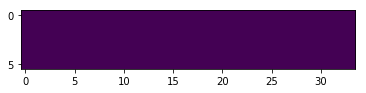

In [153]:
plt.imshow(res[30][0][3])
plt.show()

In [131]:
def return_model(pool_branches = [(2,2), (4,4), (5,5), (8,8),(10,10)]):
    nb_input_filters = 1000
    N = 36
    
    img_inputs = [Input(shape=(4,None,None)) for _ in range(2)]

    x,y = tuple(img_inputs)



    x = UpSampling2D(size=(2, 2))(x)

    merge_out = Merge(mode='max')([x,y])

    W = []
    for i in range(N):
        if i == 0:
            w = merge_out
            W.append(w)
        else:
            #if (i+2,i+2) in pool_branches:
            w = MaxPooling2D(pool_size=(i+1,i+1), strides=(1,1))(merge_out)
            W.append(w)

    model = Model(input=img_inputs, output=W)
    return model

In [132]:
model1 = return_model()

In [133]:
a = Input(shape=(4,768,1216))
b = Input(shape=(4,1344,2240))
c= resnet(a)
d = resnet(b)
x = model1([c,d])
final_model = Model(input=[a,b],output=x)

In [160]:
# This function gives the 4 corners of the rectangle in a mask with a size
# different from the image size
def get_4_points(rectangle, height,width, target_height, target_width):
    ratio_y = height/target_height
    ratio_x = width/target_width
    new_x = rectangle["x"]/ratio_x
    new_y = rectangle["y"]/ratio_y
    new_x2 = rectangle["x"]+rectangle["width"]/ratio_x
    new_y2 = rectangle["y"]+rectangle["height"]/ratio_y
    result = np.zeros((4,2))
    result[:2,0] = new_x
    result[2:,0] = new_x2
    result[0,1] = new_y
    result[2,1] = new_y
    result[1,1] = new_y2
    result[3,1] = new_y2
    result[:,0].clip(min=0, max=target_width, out=result[:,0])
    result[:,1].clip(min=0, max=target_height, out=result[:,1])
    result = result.astype(int)
    return result

In [157]:
metadata["img_00003.jpg"]

{'angle': -158.4429207149623,
 'class': 'ALB',
 'code': 2,
 'filename': 'img_00003.jpg',
 'head_tail': [{'x': 825.5028464692997, 'y': 342.8499725255559},
  {'x': 1095.1227277758048, 'y': 449.36646884417524}],
 'height': 720,
 'ht_first': True,
 'path': './train/ALB/img_00003.jpg',
 'rectangles': [{'height': 170.61000000000257,
   'width': 332.7600000000051,
   'x': 805.1100000000123,
   'y': 324.30000000000496},
  {'height': 258.03000000000395,
   'width': 377.88000000000574,
   'x': 266.49000000000404,
   'y': 135.36000000000206},
  {'height': 100.11000000000152,
   'width': 360.96000000000555,
   'x': 375.0600000000057,
   'y': 56.40000000000086},
  {'height': 105.75000000000162,
   'width': 335.58000000000516,
   'x': 690.9000000000106,
   'y': 88.83000000000135}],
 'width': 1280}

In [159]:
for i in range(2):
    for key, v in list(metadata.items())[:2]:
        if v["class"] != "NoF":
            if "rectangles" in v:
                for rec in v["rectangles"]:
                    points = get_4_points(rec, v["height"], v["width"], size[i][0], size[i][1])
                    matrice = np.zeros((1,4,1344,2240))
                    for k in range(4):
                        matrices[0,k,points[k,0],points[k,1]] = 1
                    out_branches = final_model.predict(matrice)
                    

img_01784.jpg
img_03576.jpg
img_02452.jpg
img_06588.jpg
img_06587.jpg
img_06884.jpg
img_00020.jpg
img_05135.jpg
img_04583.jpg
img_06421.jpg
img_01917.jpg
img_06536.jpg
img_06693.jpg
img_06670.jpg
img_06198.jpg
img_07465.jpg
img_04301.jpg
img_04090.jpg
img_07549.jpg
img_06656.jpg
img_06656.jpg
img_03620.jpg
img_07891.jpg
img_06340.jpg
img_02671.jpg
img_01869.jpg
img_00091.jpg
img_05804.jpg
img_07657.jpg
img_07299.jpg
img_02491.jpg
img_02342.jpg
img_01838.jpg
img_07212.jpg
img_05225.jpg
img_07545.jpg
img_06887.jpg
img_06461.jpg
img_06224.jpg
img_06873.jpg
